In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as scipy_curve_fit
from scipy.stats import poisson

from emely import curve_fit as emely_curve_fit

In [ ]:
# define plot style
violet = "#785ef0"
blue = "#648fff"
yellow = "#ffb000"
orange = "#fe6100"
red = "#dc267f"
black = "000000"
gray = "cccccc"
white = "ffffff"

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.dpi"] = 300

The goal is to estimate the parameters $a$, $\mu$, $\sigma $, and $\tau$ of a normalized and decaying Gaussian function:

$
f(x, t) = \frac{a}{\sqrt{2\pi\,\sigma^2}\cdot \tau} \, e^{-\frac{(x - \mu)^2}{2\sigma^2}} \cdot e^{-\frac{t}{\tau}}
$

from measurements

$
y(x, t) = f(x, t) + \varepsilon
$

where the noise term $ \varepsilon $ follows **Poisson statistics**. 

This setup represents, for example, an experiment aiming to determine the center and width of a Gaussian point-spread function (PSF) from photon-counting data. Here, the total number of detected photons would be $a = N_\mathrm{ph} \cdot \Delta x \cdot \Delta t$, where $\Delta x$ and $\Delta t$ are the sampling periods.

In these scenarios, least-squares optimization is not optimal because it assumes that the noise follows Gaussian statistics.  
Instead, it is more appropriate to use **maximum likelihood estimation (MLE)** formulated for **Poisson noise**. This becomes particularly relevant if the number of detected photons is low.

Here, we demonstrate how the Emely package can be used to perform parameter estimation using MLE.

In [3]:
# define the model to fit
def decaying_gaussian(x, t, a, mu, sigma, tau):
    return (
        a
        / np.sqrt(2 * np.pi * sigma**2)
        / tau
        * np.exp(-((x - mu) ** 2) / (2 * sigma**2))
        * np.exp(-t / tau)
    )

In [4]:
# define estimators
estimators = {
    "LS": lambda f, xdata, ydata, p0, bounds, sigma, absolute_sigma: scipy_curve_fit(
        f,
        xdata,
        ydata,
        p0=p0,
        bounds=bounds,
        sigma=sigma,
        absolute_sigma=absolute_sigma,
    ),
    "G-MLE": lambda f, xdata, ydata, p0, bounds, sigma, absolute_sigma: emely_curve_fit(
        f,
        xdata,
        ydata,
        p0=p0,
        bounds=bounds,
        sigma=sigma,
        absolute_sigma=absolute_sigma,
        noise="gaussian",
    ),
    "P-MLE": lambda f, xdata, ydata, p0, bounds, sigma, absolute_sigma: emely_curve_fit(
        f,
        xdata,
        ydata,
        p0=p0,
        bounds=bounds,
        sigma=sigma,
        absolute_sigma=absolute_sigma,
        noise="poisson",
    ),
}

In [5]:
# define model parameters
dx = 160e-9  # (m)
dt = 200e-12  # (s)
mu = 0  # (m)
sigma = 300e-9  # (m)
tau = 1.2e-9  # (s)
N_ph = 1e3  # number of detected photons
p = (N_ph * dx * dt, mu, sigma, tau)

# define model variables
x_rng = (-3 * sigma, 3 * sigma)
n_x = round((x_rng[1] - x_rng[0]) / dx) + 1
x = x_rng[0] + dx * np.arange(n_x)

t_rng = (0, 3 * tau)
n_t = round((t_rng[1] - t_rng[0]) / dt) + 1
t = t_rng[0] + dt * np.arange(n_t)

x, t = np.meshgrid(x, t)

# set the random seed
np.random.seed(5)

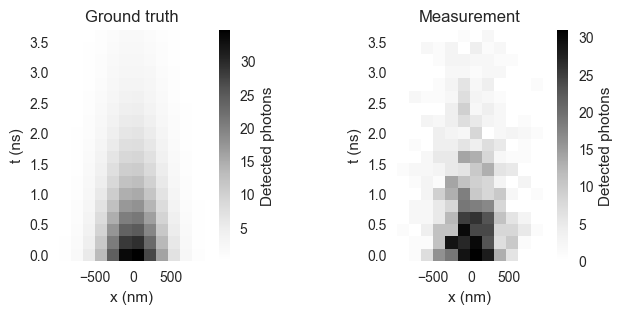

In [6]:
f_x = decaying_gaussian(x, t, *p)
y_x = poisson.rvs(f_x)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

p_1 = axs[0].pcolormesh(1e9 * x, 1e9 * t, f_x)
p_2 = axs[1].pcolormesh(1e9 * x, 1e9 * t, y_x)

axs[0].set_xlabel("x (nm)")
axs[1].set_xlabel("x (nm)")
axs[0].set_ylabel("t (ns)")
axs[1].set_ylabel("t (ns)")
axs[0].set_aspect(dx / dt)
axs[1].set_aspect(dx / dt)
axs[0].set_title("Ground truth")
axs[1].set_title("Measurement")

cb_1 = fig.colorbar(p_1, ax=axs[0])
cb_1.set_label("Detected photons")
cb_2 = fig.colorbar(p_2, ax=axs[1])
cb_2.set_label("Detected photons")

In [7]:
# define initial guesses
N_ph_0 = np.sum(y_x)
a_0 = N_ph_0 * dx * dt
mu_0 = np.sum(x * y_x) / N_ph_0  # (m)
sigma_0 = np.sqrt(np.sum((x - mu_0) ** 2 * y_x) / N_ph_0)  # (m)
tau_0 = a_0 / np.sum(y_x[0, :] * dx)  # (s)
p_0 = (a_0, mu_0, sigma_0, tau_0)

# define bounds
bounds = (
    [1e-18, -np.inf, 1e-18, 1e-18],
    [np.inf, np.inf, np.inf, np.inf],
)

In [8]:
# perform parameter estimation using different estimators
u = np.array([x.flatten(), t.flatten()])
y_u = y_x.flatten()

p_opt = {}
p_cov = {}
for name in estimators:
    p_opt[name], p_cov[name] = estimators[name](
        lambda u, *p: decaying_gaussian(*u, *p),
        u,
        y_u,
        p0=p_0,
        bounds=bounds,
        sigma=np.sqrt(y_u + 1),
        absolute_sigma=True,
    )

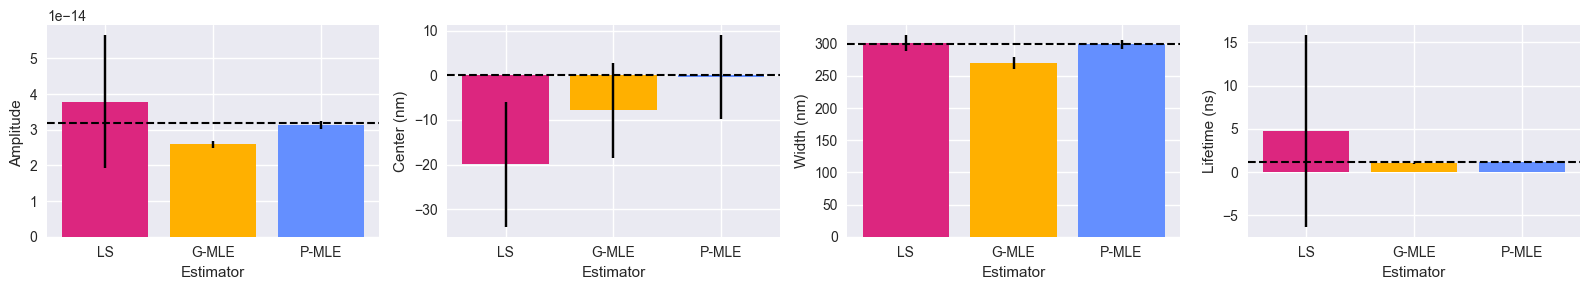

In [9]:
names = list(estimators.keys())
colors = [red, yellow, blue]
parameters = ["Amplitude", "Center", "Width", "Lifetime"]
parameter_units = ["", "(nm)", "(nm)", "(ns)"]
parameter_scaling = [1, 1e9, 1e9, 1e9]

fig, axs = plt.subplots(1, len(p), figsize=(len(p) * 4, 3))
for ii in range(len(p)):
    values = np.array([p_opt[name][ii] for name in names])
    errors = np.sqrt([p_cov[name][ii, ii] for name in names])

    axs[ii].bar(
        names,
        parameter_scaling[ii] * values,
        yerr=parameter_scaling[ii] * errors,
        color=colors,
    )

    axs[ii].axhline(
        parameter_scaling[ii] * p[ii],
        linewidth=1.5,
        linestyle="--",
        color=black,
        label="Ground truth",
    )

    axs[ii].set_xlabel("Estimator")
    axs[ii].set_ylabel(parameters[ii] + " " + parameter_units[ii])

fig.tight_layout()